In [ ]:
# %pip install xgboost
# %pip install shap

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import ROOT

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  x86_64-conda_cos6-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.20/02


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import RocCurveDisplay,roc_curve,auc,recall_score
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import glob
from sklearn.model_selection import GridSearchCV
import shap

In [ ]:
# import pandas as pd
# import numpy as np  
# import seaborn as sns 
# import matplotlib.pyplot as plt
# from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_score,KFold
# from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from scipy.stats import pearsonr
# import shap
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
# from sklearn.preprocessing import StandardScaler

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score,recall_score,roc_auc_score
# from sklearn.impute import SimpleImputer

In [35]:
%%time
folder_path = '../../Data/preprocessed/normalized/raw/pi-_10GeV_4ly_3e-4_inclined_4ly/'
file_list = glob.glob(folder_path + 'TrkData_viewy_cl_TB_2023_T10_Sept_pi-Mono_10000_inclined_10000-evt-*_pitch0.25node_df.parquet')
file_list = sorted(file_list, key=lambda x: int(x.split('evt-')[1].split('_')[0]))

CPU times: user 10.7 ms, sys: 10.4 ms, total: 21.1 ms
Wall time: 20.7 ms


In [36]:
%%time
folder_path2 = '../../Data/preprocessed/normalized/raw/pi-_10GeV_4ly_1e-4_inclined_4ly/'
file_list2 = glob.glob(folder_path2 + 'TrkData_viewy_cl_TB_2023_T10_Sept_pi-Mono_10000_inclined_10000-evt-*_pitch0.25node_df.parquet')
file_list2 = sorted(file_list2, key=lambda x: int(x.split('evt-')[1].split('_')[0]))

CPU times: user 24.5 ms, sys: 13.7 ms, total: 38.2 ms
Wall time: 36.4 ms


In [37]:
%%time
file_list=file_list[:250]+file_list2[:250]

node_df_pi = pd.DataFrame()

for file_path in file_list:
    df = pd.read_parquet(file_path)
    node_df_pi = pd.concat([node_df_pi, df], ignore_index=True)

CPU times: user 50.7 s, sys: 47 s, total: 1min 37s
Wall time: 2min 33s


In [40]:
%%time
node_df_pi=node_df_pi.drop(columns=['Ev'])
node_df_pi=node_df_pi.drop(columns=['idx_node'])
node_df_pi=node_df_pi.drop(columns=['yMC'])

CPU times: user 219 ms, sys: 110 ms, total: 329 ms
Wall time: 319 ms


CPU times: user 283 ms, sys: 30.3 ms, total: 314 ms
Wall time: 281 ms


<AxesSubplot: >

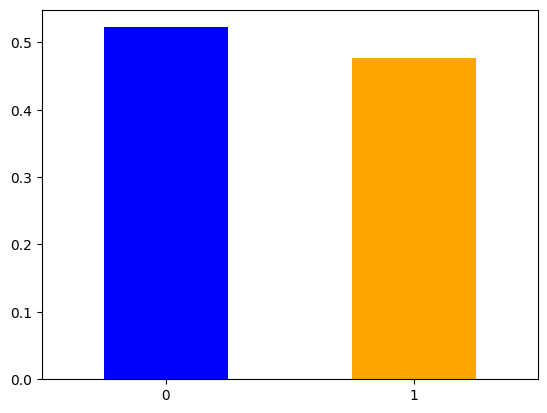

In [41]:
%%time
hit_count = node_df_pi['hit_class'].value_counts().sort_index()
hit_count/=len(node_df_pi)
hit_count.plot(kind='bar', rot=1, color=['blue', 'orange'])

In [121]:
node_df_pi.head()

,ly,y_hit,zy_hit,dy_hit,PE,PID,hit_class
0,0,0.326,-29.534,0.06,24,-211.0,1
1,0,14.298,-29.534,2.36,9,-999.0,0
2,1,6.249,1165.594,0.92,11,-211.0,1
3,1,9.659,1165.594,2.02,10,-999.0,0
4,2,6.531,1207.858,0.77,39,-211.0,1


In [13]:
%%time
X = node_df_pi.drop(['hit_class','PID'],axis=1)


y=node_df_pi.hit_class
y_true=list()
y_pred=list()
y_testlist=[]
all_prob=[]

#rfc=XGBClassifier(random_state=0)


accuracy=[]
sensitivity=[]
specificity=[]
rocauc=[]
list_shap_values=[]
list_test_sets=[]   

# for i in range(0,50):
subject=[]
label=[]
y_hat=[]
prob=[]
#kfold=StratifiedKFold(n_splits=5,random_state=i,shuffle=True)
df=node_df_pi#.drop(['Subject','Label'],axis=1)
#df.reset_index(inplace=True)
kfold=RepeatedStratifiedKFold(n_splits=5,n_repeats=1,random_state=0)#1/10 sono i dati del test, i restanti al train
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

for k, (train_index,test_index) in enumerate(kfold.split(df,y)):

    #rfc=RandomForestClassifier(random_state=0)
    rfc=XGBClassifier(random_state=0)

    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    y_train = y[train_index]
    
    y_val=y.iloc[test_index]

    #try simpleinputer
    # imputer = imputer.fit(X_train)
    # X_train=imputer.transform(X_train)
    # X_val=imputer.transform(X_val)
        

    pipe_lr=make_pipeline(StandardScaler(),rfc
                          )
    
    pipe_lr.fit(X_train,y_train)
  

  


    label=np.append(label,y_val.values).astype(int)
    y_hats=pipe_lr.predict(X_val)
    y_hat=np.append(y_hat,y_hats).astype(int)
    #y_hat.append(y_hats)
    
    probs=pipe_lr.predict_proba(X_val)[:,1]
    prob=np.append(prob,probs)
  

    y_testlist.append(y_val)
    all_prob.append(prob)
    
     
    #explaining model
    explainer =  shap.Explainer(rfc,X_train,model_output='probability')      
    shap_values=explainer(X_val)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values.append(shap_values)
    list_test_sets.append(test_index)
    
    
    ## #SHAP VALUES 
    # explainer = shap.TreeExplainer(rfc)
    # shap_values = explainer.shap_values(X_val)
    # #for each iteration we save the test_set index and the shap_values
    # list_shap_values.append(shap_values)
    # list_test_sets.append(test_index)

    
    acc=accuracy_score(label, y_hat)
    sens=recall_score(label, y_hat,pos_label=1)
    spec=recall_score(label, y_hat,pos_label=0)
    accuracy.append(acc)
    sensitivity.append(sens)
    specificity.append(spec)

    auc=roc_auc_score(label,prob)
    rocauc.append(auc)

In [24]:
    
print('Accuracy: %.4f +/- (%.4f):\nSensitivity: %.3f +/- (%.4f):\nSpecificity: %.4f +/- (%.4f):\nROC AUC: %.4f +/- (%.4f)' % (np.mean(accuracy),np.std(accuracy),np.mean(sensitivity),np.std(sensitivity),np.mean(specificity),np.std(specificity),np.mean(rocauc),np.std(rocauc)))

Accuracy: 0.9611 +/- (0.0003):
Sensitivity: 0.969 +/- (0.0003):
Specificity: 0.9536 +/- (0.0003):
ROC AUC: 0.9897 +/- (0.0001)


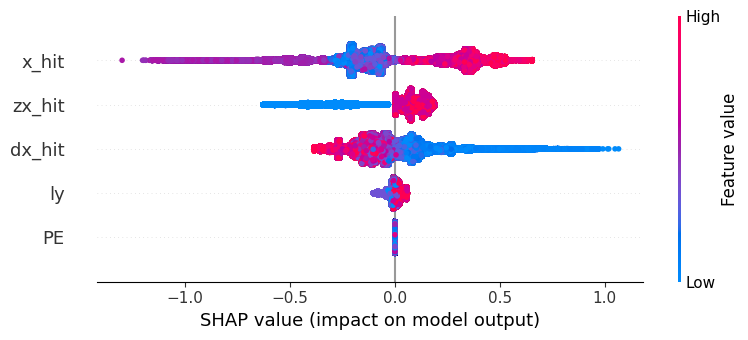

In [20]:
#%%
#combining results from all iterations
test_set = list_test_sets[0]
shapValue = np.array(list_shap_values[0].values)

for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    shapValue = np.concatenate((shapValue,np.array(list_shap_values[i].values)),axis=0)
#bringing back variable names
X_test = node_df_pi.drop(['hit_class','PID'],axis=1).iloc[test_set]
X_val = pd.DataFrame(node_df_pi.iloc[test_set],columns=node_df_pi.iloc[:,:].columns)
shap.summary_plot(shapValue,X_test,feature_names=X_test.columns)#,plot_type='layered_violin')

In [21]:
# #%%Random forest
# #%%
# #combining results from all iterations
# test_set = list_test_sets[0] 
# shap_values = np.array(list_shap_values[0])
# for i in range(1,len(list_test_sets)):
#     test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
#     shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)#da problemi perchè l'ultimo fold è da 21 righe mentre gli altri sono da 22
#     #shap_values=np.row_stack((shap_values,np.array(list_shap_values[i])))
# #print(type(pd_abundance_T))
# #pd_abundance_T.info()
# #bringing back variable names  
# columns=X.columns
# #print(columns)
# X_val = pd.DataFrame(node_df_pi.iloc[test_set],columns=columns)
# #X_val.drop(['provincia','morti reali','morti attese'],axis=1,inplace=True)
# shap.summary_plot(shap_values[1], X_val, feature_names=columns)

In [32]:
node_df_pi.head()

,ly,x_hit,zx_hit,dx_hit,PE,PID,hit_class
0,0,-1.733,-30.621,0.21,37,-211.0,1
1,0,3.451,-30.621,0.65,12,-999.0,0
2,1,7.341,1164.535,1.07,22,-211.0,1
3,2,7.552,1202.035,0.99,28,-211.0,1
4,3,-5.549,1787.392,1.06,12,-999.0,0


In [42]:
%%time
# # param_grid = {
# #     'max_depth': [3, 5, 7],
# #     'learning_rate': [0.1, 0.01, 0.001],
# #     'subsample': [0.5, 0.7, 1],
# #     'reg_alpha':[0, 0.5, 1, 5],
# #     'reg_lambda':[0, 0.5, 1, 5]   
# # }
xgb_model = xgb.XGBClassifier()
# Fit the GridSearchCV object to the training data
X_train, X_test, y_train, y_test = train_test_split(node_df_pi.iloc[:,:-2], node_df_pi.iloc[:,-1], test_size=0.2, random_state=0)
xgb_model.fit(X_train, y_train)


CPU times: user 6min 34s, sys: 2.94 s, total: 6min 37s
Wall time: 34.4 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
predictions = xgb_model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
recall=recall_score(y_test, predictions)
precision=precision_score(y_test, predictions)

In [14]:
print(accuracy, recall, precision)

0.9608585328538312 0.968584130433217 0.9516931832924197


In [125]:
X_test

,ly,y_hit,zy_hit,dy_hit,PE
1179799,0,-10.734,-29.317,2.00,7
13965630,3,-13.216,1788.441,2.09,10
135260,2,1.184,1207.955,0.25,10
23751491,1,-3.868,1165.680,0.53,19
8784892,3,0.805,1788.465,0.10,29
...,...,...,...,...,...
8996926,0,1.367,-29.558,0.27,12
18026428,3,9.548,1788.358,1.07,38
19077604,2,9.413,1207.858,0.80,70
21855655,3,-6.591,1788.298,1.29,11


In [44]:
df_test=pd.read_parquet("../../Data/preprocessed/raw/pi-_10GeV_4ly_3e-4_inclined_4ly/TrkData_viewy_cl_TB_2023_T10_Sept_pi-Mono_10000_inclined_10000-evt-800_pitch0.25node_df.parquet")

In [45]:
data_trk=pd.read_parquet("../../Data/preprocessed/raw/pi-_10GeV_4ly_3e-4_inclined_4ly/TrkData_viewy_cl_TB_2023_T10_Sept_pi-Mono_10000_inclined_10000-evt-800_pitch0.25node_df.parquet")

In [46]:
df_class=df_test[['Ev','hit_class']]
df_test=df_test.drop(columns=['idx_node'])
df_test=df_test.drop(columns=['yMC'])
df_test=df_test.drop(columns=['hit_class'])
df_test=df_test.drop(columns=['PID'])

In [52]:
df=df_test

In [53]:
pred=xgb_model.predict(df_test.iloc[:,1:])

In [130]:
pred

array([0, 1, 0, ..., 0, 0, 1])

In [54]:
new_column_series = pd.Series(pred, index=data_trk.index)
df_class['pred']=new_column_series

In [55]:
new_column_series

3        0
3        0
3        0
4        0
4        1
        ..
37432    1
37433    0
37433    1
37434    0
37434    0
Length: 80030, dtype: int64

In [56]:
df_class.Ev.unique()

array([   1,    3,    4, ..., 9995, 9997, 9998])

In [57]:
df_class_selected = df_class[df_class['pred'] != df_class['hit_class']]


In [58]:
df_class_selected.Ev.nunique()

7478

In [59]:
df_class.Ev.nunique()

7479

In [60]:
df_class_selected

,Ev,hit_class,pred
3,1,1,0
4,1,0,1
4,1,0,1
4,1,0,1
4,1,0,1
...,...,...,...
37432,9998,0,1
37432,9998,0,1
37433,9998,1,0
37433,9998,0,1


In [61]:
data_trk['pred']=new_column_series

In [62]:
data_trk.head()

,Ev,ly,y_hit,zy_hit,dy_hit,PE,PID,yMC,hit_class,idx_node,pred
3,1,0,-16.092,-29.503,0.04,4,-999.0,5.265312,0,0,0
3,1,0,5.095,-29.503,0.66,31,-211.0,5.265312,1,1,0
3,1,0,14.816,-29.503,2.53,8,-999.0,5.265312,0,2,0
4,1,1,-10.952,1165.537,1.82,9,-999.0,6.620134,0,3,0
4,1,1,3.159,1165.537,0.56,14,-999.0,6.620134,0,4,1


In [27]:
data_trk.Ev.unique()

array([   1,    3,    4, ..., 9995, 9997, 9998])

In [29]:
%%time
# gr=ROOT.TGraph(len(np.array(x_pred)),np.array(x_pred),np.array(z_pred))
# c1=ROOT.TCanvas()
# c1.cd()
# gr.GetXaxis().SetLimits(-20.0,20.0);
# gr.GetXaxis().SetTitle('x [mm]')
# gr.GetYaxis().SetTitle('z [mm]')
# gr.SetMarkerStyle(8)
# gr.Draw('AP')
myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/pred_data_xz_ml.root','RECREATE')
# gr.Write()
# c1.Write()

         
ly_ev=[]
x_ev=[]
z_ev=[]
pe_ev=[]
dx_ev=[]
no_good_ev=[]
events=data_trk.Ev.unique()
for i in range(0,len(events)): 
    # print('ev ', i)    
    ev=events[i]
    ly_ev.append([])
    x_ev.append([])
    z_ev.append([])
    pe_ev.append([])
    dx_ev.append([])
    # print(len(data_trk[data_trk.Ev==ev]))
    tmp_ev_sel=data_trk[data_trk.Ev==ev]
    for j in range(0,len(tmp_ev_sel)):        
        if(tmp_ev_sel.pred.iloc[j]==1):
            # print('***')
            tmp_ly=tmp_ev_sel.ly.iloc[j]
            # print('_____',tmp_ly)
            tmp_x=tmp_ev_sel.x_hit.iloc[j]
            tmp_z=tmp_ev_sel.zx_hit.iloc[j]
            tmp_dx=tmp_ev_sel.dx_hit.iloc[j]
            # print(tmp_dx)
            tmp_pe=tmp_ev_sel.PE.iloc[j]
                
        # print(tmp_pe)
    ly_ev[i].append(tmp_ly)
    x_ev[i].append(tmp_x)
    z_ev[i].append(tmp_z)
    dx_ev[i].append(tmp_dx)
    pe_ev[i].append(tmp_pe)


OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
ly_ev_vec = ROOT.std.vector("float")()
x_ev_vec = ROOT.std.vector("float")()
z_ev_vec = ROOT.std.vector("float")()
dx_ev_vec = ROOT.std.vector("float")()
pe_ev_vec = ROOT.std.vector("float")()
no_good_ev_vec=ROOT.std.vector("int")()
OutTree.Branch("ly_ev_vec", ly_ev_vec)
OutTree.Branch("x_ev_vec", x_ev_vec)
OutTree.Branch("z_ev_vec", z_ev_vec)
OutTree.Branch("dx_ev_vec", dx_ev_vec)
OutTree.Branch("pe_ev_vec", pe_ev_vec)
OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
# print(x_ev)
for no_good in no_good_ev:
    no_good_ev_vec.push_back(no_good)
for l,x,z,dx,pe in zip(ly_ev,x_ev,z_ev,dx_ev,pe_ev):
    
    # Clear the contents of the vector
    ly_ev_vec.clear()
    x_ev_vec.clear()
    z_ev_vec.clear()
    dx_ev_vec.clear()
    pe_ev_vec.clear()
    
    # Replace the contents in the vector with the contents
    # from the current array
    ly_ev_vec.reserve(len(l))
    x_ev_vec.reserve(len(x))
    z_ev_vec.reserve(len(z))
    dx_ev_vec.reserve(len(dx))
    pe_ev_vec.reserve(len(pe))
    

    for il in l:
        ly_ev_vec.push_back(il)
    for ix in x:
        x_ev_vec.push_back(ix)
    for iz in z:
        z_ev_vec.push_back(iz)
    for idx in dx:
        dx_ev_vec.push_back(idx)
    for ipe in pe:
        pe_ev_vec.push_back(ipe)
        
        
    OutTree.Fill()

OutTree.Write()
myfile.Close()

NameError: name 'tmp_ly' is not defined

In [63]:
%%time
# gr=ROOT.TGraph(len(np.array(x_pred)),np.array(x_pred),np.array(z_pred))
# c1=ROOT.TCanvas()
# c1.cd()
# gr.GetXaxis().SetLimits(-20.0,20.0);
# gr.GetXaxis().SetTitle('x [mm]')
# gr.GetYaxis().SetTitle('z [mm]')
# gr.SetMarkerStyle(8)
# gr.Draw('AP')
myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/pred_data_yz_ml.root','RECREATE')
# gr.Write()
# c1.Write()

         
ly_ev=[]
y_ev=[]
z_ev=[]
pe_ev=[]
dy_ev=[]
no_good_ev=[]
events=data_trk.Ev.unique()
for i in range(0,len(events)): 
    # print('ev ', i)    
    ev=events[i]
    ly_ev.append([])
    y_ev.append([])
    z_ev.append([])
    pe_ev.append([])
    dy_ev.append([])
    # print(len(data_trk[data_trk.Ev==ev]))
    tmp_ev_sel=data_trk[data_trk.Ev==ev]
    for j in range(0,len(tmp_ev_sel)):        
        if(tmp_ev_sel.pred.iloc[j]==1):
            # print('***')
            tmp_ly=tmp_ev_sel.ly.iloc[j]
            # print('_____',tmp_ly)
            tmp_y=tmp_ev_sel.y_hit.iloc[j]
            tmp_z=tmp_ev_sel.zy_hit.iloc[j]
            tmp_dy=tmp_ev_sel.dy_hit.iloc[j]
            # print(tmp_dx)
            tmp_pe=tmp_ev_sel.PE.iloc[j]
                
        # print(tmp_pe)
    ly_ev[i].append(tmp_ly)
    y_ev[i].append(tmp_y)
    z_ev[i].append(tmp_z)
    dy_ev[i].append(tmp_dy)
    pe_ev[i].append(tmp_pe)

OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
ly_ev_vec = ROOT.std.vector("float")()
y_ev_vec = ROOT.std.vector("float")()
z_ev_vec = ROOT.std.vector("float")()
dy_ev_vec = ROOT.std.vector("float")()
pe_ev_vec = ROOT.std.vector("float")()
no_good_ev_vec=ROOT.std.vector("int")()
OutTree.Branch("ly_ev_vec", ly_ev_vec)
OutTree.Branch("y_ev_vec", y_ev_vec)
OutTree.Branch("z_ev_vec", z_ev_vec)
OutTree.Branch("dy_ev_vec", dy_ev_vec)
OutTree.Branch("pe_ev_vec", pe_ev_vec)
OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
# print(x_ev)
for no_good in no_good_ev:
    no_good_ev_vec.push_back(no_good)
for l,y,z,dy,pe in zip(ly_ev,y_ev,z_ev,dy_ev,pe_ev):
    
    # Clear the contents of the vector
    ly_ev_vec.clear()
    y_ev_vec.clear()
    z_ev_vec.clear()
    dy_ev_vec.clear()
    pe_ev_vec.clear()
    
    # Replace the contents in the vector with the contents
    # from the current array
    ly_ev_vec.reserve(len(l))
    y_ev_vec.reserve(len(y))
    z_ev_vec.reserve(len(z))
    dy_ev_vec.reserve(len(dy))
    pe_ev_vec.reserve(len(pe))
    

    for il in l:
        ly_ev_vec.push_back(il)
    for iy in y:
        y_ev_vec.push_back(iy)
    for iz in z:
        z_ev_vec.push_back(iz)
    for idy in dy:
        dy_ev_vec.push_back(idy)
    for ipe in pe:
        pe_ev_vec.push_back(ipe)
        
        
    OutTree.Fill()

OutTree.Write()
myfile.Close()

CPU times: user 6.35 s, sys: 173 ms, total: 6.52 s
Wall time: 7.47 s
